## Woodline Partners QR Data Assignment

### Problem Statement 

We are evaluating a new data set that captures US store transactions for 11 different companies over 6 months. Each row should represent how many of a specific item a user bought from a company on a given day. We want to understand if this data would have been a good predictor of reported company sales. Your task is to explore the transaction data in 'TransactionData.csv' and compare it to the results reported in 'ReportedData.csv', guided by the questions below:

#### Let us import all the required libraries for this jupyter notebook and keep adding as we proceed with the assignment. Additionally, one can reformat scientific notation as it isn't helpful when you are trying to make quick comparisons across your DataFrame, and when your values are not that long. 

In [1]:
## we start with importing the required libraries

from __future__ import division

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display
import sklearn
from scipy import stats
from sklearn.cluster import KMeans
import plotly.express as px
import statsmodels.api as sm

## for visualizations

import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.globals import ThemeType
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
## From the graphs, we observed that scientific notation is not helpful, hence I changed the display formatting: 

pd.options.display.float_format = '{:.3f}'.format

### Question 1: Are there any data quality issues with this data set? If so, what did you need to clean up?

### Data Profiling & Data Cleaning

Data cleaning is the process of editing, correcting, and structuring data within a data set so that it’s generally uniform and prepared for analysis. This includes removing corrupt or irrelevant data and formatting it into a language that computers can understand for optimal analysis.

Before we jump onto cleaning our data quality issues, let us first examine, analyze, and create useful summaries of our data (i.e. Data Profiling)

In [3]:
## we now import our item level and company level datasets and have a quick look at their dataframes

reported_data = pd.read_csv('ReportedData.csv')
transaction_data = pd.read_csv('TransactionData.csv')

In [4]:
reported_data.head(5)

company report_period_start report_period_end  reported_sales
0  Company A          01/07/2005        30/09/2005       632434016
1  Company B          01/07/2005        30/09/2005      1130209885
2  Company C          01/07/2005        30/09/2005       880349619
3  Company D          01/07/2005        30/09/2005      1110601241
4  Company E          01/07/2005        30/09/2005       744004104

In [5]:
transaction_data.head(5)

Date     company  item_id  item_price  item_quantity  user_id
0  2005-08-24   Company I     8944      43.990              6  3654692
1  2005-12-03  Company G      6742      93.990              7  3613209
2  2005-10-28   Company J     9819      41.990              9  3662109
3  22/12/2005   Company H     4761      76.990              9  3234797
4  2005-11-02   Company D     6672      15.990             11  3493528

### Exploratory Data Analysis on our dataframes

Although reported_data dataframe is part of the dependent variable dataset - basically we use this to check the actual data, it is important that we do some preliminary data analysis on reported data, prior to making any inaccurate conclusions on our forecasts

In [6]:
reported_data.info()
## reported_data.dtypes
reported_data.shape
reported_data.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company              22 non-null     object
 1   report_period_start  22 non-null     object
 2   report_period_end    22 non-null     object
 3   reported_sales       22 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 832.0+ bytes


company report_period_start report_period_end  reported_sales
count          22                  22                22          22.000
unique         11                   2                 2             NaN
top     Company A          01/07/2005        30/09/2005             NaN
freq            2                  11                11             NaN
mean          NaN                 NaN               NaN   888725809.545
std           NaN                 NaN               NaN   286738262.695
min           NaN                 NaN               NaN   442613764.000
25%           NaN                 NaN               NaN   676538872.250
50%           NaN                 NaN               NaN   836390447.000
75%           NaN                 NaN               NaN  1078528186.000
max           NaN                 NaN               NaN  1485545932.000

In [7]:
## reported_data.isnull().sum()

#### We have made the following inferences on the data quality of the reported_data: 
1. There are no null values 
2. There are 11 different (unique) companies that appear twice as we are provided with Q3 and Q4 data of 2005. 
3. There are no anomalies as such in the reported sales, although we can verify this further with the transaction data
4. report_period_start and report_period_end are given as object datatypes, but they could be convert into datetime format

Hence, the data quality for report_data has been checked.


In [8]:
# convert column to datetime pandas
reported_data['report_period_start'] = pd.to_datetime(reported_data['report_period_start'])
reported_data['report_period_end'] = pd.to_datetime(reported_data['report_period_end'])

In [9]:
## check that now your date columns are with the right datatype
reported_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              22 non-null     object        
 1   report_period_start  22 non-null     datetime64[ns]
 2   report_period_end    22 non-null     datetime64[ns]
 3   reported_sales       22 non-null     int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 832.0+ bytes


### Assuming reported data is our 'source of truth', we can quickly visualize the reported sales to give us a fair understanding on how each company has been performing over Q3-Q4 2005. This helps us with data sanity before we start modelling the alternative transactional data

In [10]:
reported_data['report_quarter'] = reported_data['report_period_end'].dt.to_period('Q')
reported_data

company report_period_start report_period_end  reported_sales  \
0   Company A          2005-01-07        2005-09-30       632434016   
1   Company B          2005-01-07        2005-09-30      1130209885   
2   Company C          2005-01-07        2005-09-30       880349619   
3   Company D          2005-01-07        2005-09-30      1110601241   
4   Company E          2005-01-07        2005-09-30       744004104   
5   Company F          2005-01-07        2005-09-30       732961358   
6   Company G          2005-01-07        2005-09-30       567538584   
7   Company H          2005-01-07        2005-09-30       982309021   
8   Company I          2005-01-07        2005-09-30       739365502   
9   Company J          2005-01-07        2005-09-30       792431275   
10  Company K          2005-01-07        2005-09-30      1223167752   
11  Company A          2005-01-10        2005-12-31       657731377   
12  Company B          2005-01-10        2005-12-31       903037698   
13  Company C          2005-01-10        2005-12-31       924367100   
14  Company D          2005-01-10        2005-12-31      1344938103   
15  Company E          2005-01-10        2005-12-31       739986482   
16  Company F          2005-01-10        2005-12-31       605059601   
17  Company G          2005-01-10        2005-12-31       571511354   
18  Company H          2005-01-10        2005-12-31      1485545932   
19  Company I          2005-01-10        2005-12-31       442613764   
20  Company J          2005-01-10        2005-12-31       981029918   
21  Company K          2005-01-10        2005-12-31      1360774124   

   report_quarter  
0          2005Q3  
1          2005Q3  
2          2005Q3  
3          2005Q3  
4          2005Q3  
5          2005Q3  
6          2005Q3  
7          2005Q3  
8          2005Q3  
9          2005Q3  
10         2005Q3  
11         2005Q4  
12         2005Q4  
13         2005Q4  
14         2005Q4  
15         2005Q4  
16         2005Q4  
17         2005Q4  
18         2005Q4  
19         2005Q4  
20         2005Q4  
21         2005Q4

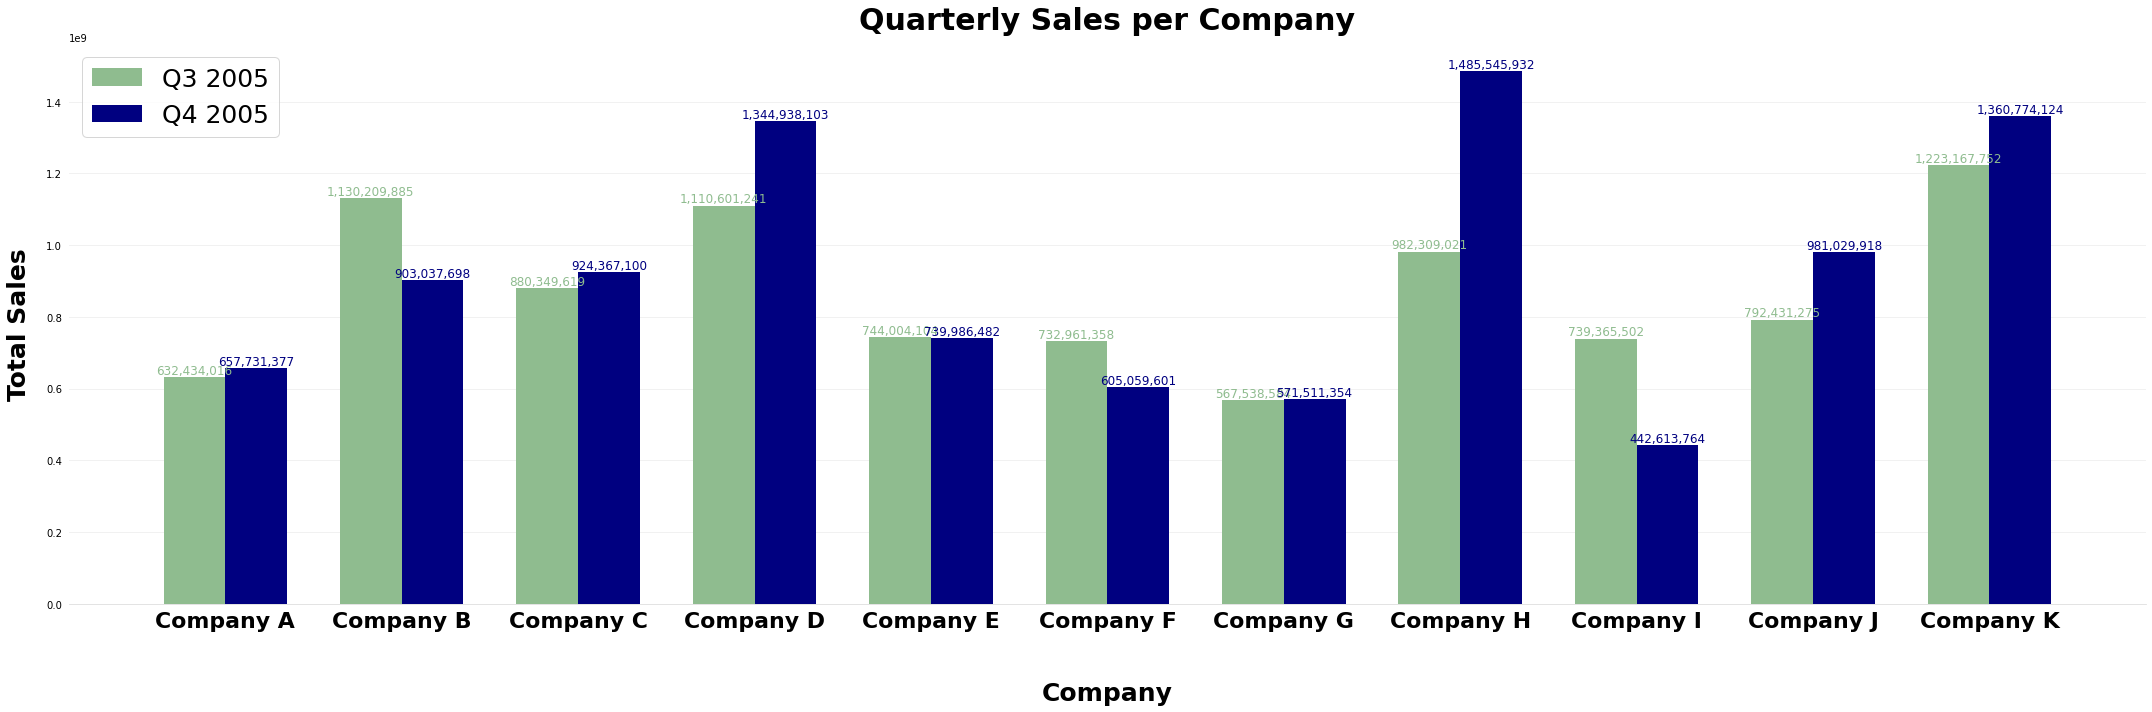

In [11]:
fig, ax = plt.subplots(figsize=(30, 10))
x = np.arange(len(reported_data.company.unique()))
bar_width = 0.35
b1 = ax.bar(x, reported_data.loc[reported_data['report_quarter'] == '2005Q3', 'reported_sales'],
            width=bar_width,color="darkseagreen",label='Q3 2005')
b2 = ax.bar(x + bar_width, reported_data.loc[reported_data['report_quarter'] == '2005Q4', 'reported_sales'],
            width=bar_width,color="navy",label='Q4 2005')

# Fix the axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(reported_data.company.unique(),size=22,fontweight="bold")

ax.legend(loc=2, prop={'size': 25})

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Company', labelpad=50, size=25, fontweight="bold")
ax.set_ylabel('Total Sales', labelpad=15, size=25,fontweight="bold")
ax.set_title('Quarterly Sales per Company', pad=15, size=30,fontweight="bold")

fig.tight_layout()

for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)


#### Company H, D, and K on an average have the highest quarterly sales amongst the eleven unique firms

Now that we have a basic idea around the reported_data dataset (our dataset to confirm predicive power of alternative data), we can look at the transaction level data and perform a data sanity check to query data quality issues

## Data Exploration - Transaction Data

In [12]:
display(transaction_data.info())
## transaction_data.dtypes
display(transaction_data.shape)
display(transaction_data.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314559 entries, 0 to 2314558
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Date           object 
 1   company        object 
 2   item_id        int64  
 3   item_price     float64
 4   item_quantity  int64  
 5   user_id        int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 106.0+ MB


None

(2314559, 6)

Date    company     item_id  item_price  item_quantity  \
count      2314559    2314559 2314559.000 2314559.000    2314559.000   
unique         184        110         NaN         NaN            NaN   
top     2005-11-17  Company H         NaN         NaN            NaN   
freq         15197     177698         NaN         NaN            NaN   
mean           NaN        NaN    5482.404      66.320          9.835   
std            NaN        NaN    3026.275    2939.501          5.011   
min            NaN        NaN      41.000       1.990          1.000   
25%            NaN        NaN    2907.000      36.990          6.000   
50%            NaN        NaN    6129.000      59.990          9.000   
75%            NaN        NaN    8508.000      82.990         13.000   
max            NaN        NaN    9819.000  999999.000         30.000   

           user_id  
count  2314559.000  
unique         NaN  
top            NaN  
freq           NaN  
mean   3499869.503  
std     288737.952  
min    3000003.000  
25%    3249250.000  
50%    3500115.000  
75%    3749712.000  
max    4000000.000

In [13]:
## lets check for the nan values
display(transaction_data.isna().sum())

Date             0
company          0
item_id          0
item_price       0
item_quantity    0
user_id          0
dtype: int64

In [14]:
## The describe method for numeric columns doesn't list the number of unique values, since this is usually not particularly meaningful for numeric data, the describe method for string columns does:

## except the company column, it is difficult to identify whether the unique values are correct or not 

display(transaction_data.nunique())

## duplicates are very common with ecommerce data, can be due to customer input error, importing and exporting errors, or even mistakes from your team 

display(transaction_data.duplicated().sum())

Date                184
company             110
item_id              55
item_price           56
item_quantity        30
user_id          489468
dtype: int64

20637

In [15]:
z = np.abs(stats.zscore(transaction_data['item_price']))
print(z)
threshold = 3
# Position of the outlier, Any z-score greater than 3 or less than -3 is considered to be an outlier.
print(np.where(z > 3))

0         0.008
1         0.009
2         0.008
3         0.004
4         0.017
           ... 
2314554   0.007
2314555   0.004
2314556   0.004
2314557   0.016
2314558   0.002
Name: item_price, Length: 2314559, dtype: float64
(array([  10416,  113096,  194829,  261887,  267922,  318267,  341287,
        693635,  790288,  796195,  830548,  923358,  945653, 1087014,
       1277416, 1303099, 1690593, 1774147, 2143308, 2256798]),)


### Data Sanity Points

- Item quantity does not have decimal values, quantity is a whole number and cannot have decimal values 
- The unique values for date roughly matches the number of days within a half year.

### Data Quality Issue 1 - Unique Values (only categorical data from describe function)

We are supposed to have 11 different companies over 6 months, but the summary table shows that we have 110 unique companies. 

### Data Quality Issue 2 - Date is not in the correct datetime format

Date and datetime are an object in Python, so when you manipulate them, you are actually manipulating objects and not string or timestamps

### Data Quality Issue 3 - Item_price seems to have an outlier data point
We don't need to check item_id and user_id as they are identification columns, but when you check the data for item_qty, it does not seem way off the 75% value, but for item_price, it does seem a bit off compared to it's 75% value at 82.990. 

### Data Quality Issue 4 - Duplicate Values

We have over 20,637 rows out of 2,314,559 rows (~1% of the data) that are duplicates, not a major issue, but still part of the data quality check

### Solving Data Quality Issues: Data Preprocessing (Cleanup)

Along with the cleanup, we will also rerun a few commands from above to ensure that we have the right set of data now

#### Data Quality Issue 1 - Unique Values (only categorical data from describe function)

The unique identification for a company is based on its letter and nothing else, hence let's remove the rest of the words and spaces from the string - for example Company A becomes 'A' and nothing else.

In [16]:
txn_data_clean = transaction_data
txn_data_clean.company = txn_data_clean.company.str.strip()
txn_data_clean.company = txn_data_clean.company.str[-1]

## Remove spaces at the beginning and at the end of the string:
## txn_data_clean.company = txn_data_clean.company.str.strip()

display(txn_data_clean.nunique())
display(txn_data_clean.isna().sum())

## the best way to deal with null values in the company column is to drop that set of rows from our data, as we don't need to predict an aggregate level figure and attributing it to a certain company can be difficult
txn_data_clean = txn_data_clean.dropna(axis=0)
display(txn_data_clean.isna().sum())

Date                184
company              11
item_id              55
item_price           56
item_quantity        30
user_id          489468
dtype: int64

Date             0
company          0
item_id          0
item_price       0
item_quantity    0
user_id          0
dtype: int64

Date             0
company          0
item_id          0
item_price       0
item_quantity    0
user_id          0
dtype: int64

#### Data Quality Issue 2 - Date is not in the correct datetime format: convert column to datetime pandas

In [17]:
txn_data_clean['Date'] = pd.to_datetime(txn_data_clean['Date'])
display(min(txn_data_clean.Date))
display(max(txn_data_clean.Date))

Timestamp('2005-07-01 00:00:00')

Timestamp('2005-12-31 00:00:00')

#### Data Quality Issue 4 - Duplicate Values

Note, it is very much possible that we have greater number of duplicate rows compared to our previous unclean set as we did not unique identifiers per company, 'company A' and 'company company a' were taken as different rows

In [18]:
display(txn_data_clean.duplicated().sum())
txn_data_clean=txn_data_clean.drop_duplicates()
display(txn_data_clean.duplicated().sum())

37559

0

#### Data Quality Issue 3 - Item_price seems to have an outlier data point

Using IQR, we can follow the below approach to replace the outliers with a NULL value. We could have imputed the missing values with Mean, median or Knn imputed values, but there were only 20 values in the price column that were null and hence it would not make a big difference in our dataset.

In [19]:
for x in ['item_price']:
    q75,q25 = np.percentile(txn_data_clean.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    txn_data_clean.loc[txn_data_clean[x] < min,x] = np.nan
    txn_data_clean.loc[txn_data_clean[x] > max,x] = np.nan

display(txn_data_clean.isnull().sum())
txn_data_clean = txn_data_clean.dropna(axis = 0)
display(txn_data_clean.isnull().sum())

Date              0
company           0
item_id           0
item_price       20
item_quantity     0
user_id           0
dtype: int64

Date             0
company          0
item_id          0
item_price       0
item_quantity    0
user_id          0
dtype: int64

In [20]:
display(txn_data_clean.info())
display(txn_data_clean.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276980 entries, 0 to 2314558
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   company        object        
 2   item_id        int64         
 3   item_price     float64       
 4   item_quantity  int64         
 5   user_id        int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 121.6+ MB


None

Date  company     item_id  item_price  item_quantity  \
count               2276980  2276980 2276980.000 2276980.000    2276980.000   
unique                  184       11         NaN         NaN            NaN   
top     2005-11-29 00:00:00        K         NaN         NaN            NaN   
freq                  13944   207396         NaN         NaN            NaN   
first   2005-07-01 00:00:00      NaN         NaN         NaN            NaN   
last    2005-12-31 00:00:00      NaN         NaN         NaN            NaN   
mean                    NaN      NaN    5476.722      57.584          9.834   
std                     NaN      NaN    3034.880      28.250          4.911   
min                     NaN      NaN      41.000       1.990          1.000   
25%                     NaN      NaN    2888.000      36.990          6.000   
50%                     NaN      NaN    6129.000      59.990          9.000   
75%                     NaN      NaN    8508.000      82.990         13.000   
max                     NaN      NaN    9819.000     100.990         30.000   

           user_id  
count  2276980.000  
unique         NaN  
top            NaN  
freq           NaN  
first          NaN  
last           NaN  
mean   3499891.019  
std     288730.610  
min    3000003.000  
25%    3249283.000  
50%    3500157.000  
75%    3749691.500  
max    4000000.000

In [21]:
## txn_data_clean.isna().sum()

## Hence data quality issues have been resolved and the data has been cleaned up

### Question 2) Are there any companies for which this data set would have been a good predictor?
### Question 3) Are there any companies for which this data set would have been a bad predictor?

We will club these questions as they would have a similar analysis and conclusions

In [22]:
## for prediction purposes,lets add more columns to the existing dataset 

txn_data_clean["predicted_sales"]=txn_data_clean["item_price"]*txn_data_clean["item_quantity"]
txn_data_clean['report_quarter'] = txn_data_clean['Date'].dt.to_period('Q')
txn_data_clean['report_month'] = txn_data_clean['Date'].dt.to_period('M')
txn_data_clean
## to check if there is any data imbalance between companies, but seems like the size is the same across firms
## txn_data_clean.groupby(['company']).size().sort_values(ascending =False)

Date company  item_id  item_price  item_quantity  user_id  \
0       2005-08-24       I     8944      43.990              6  3654692   
1       2005-12-03       G     6742      93.990              7  3613209   
2       2005-10-28       J     9819      41.990              9  3662109   
3       2005-12-22       H     4761      76.990              9  3234797   
4       2005-11-02       D     6672      15.990             11  3493528   
...            ...     ...      ...         ...            ...      ...   
2314554 2005-07-30       K     6129      44.990             15  3857340   
2314555 2005-10-03       K     2757      55.990              4  3724095   
2314556 2005-10-21       K     2757      55.990              7  3673418   
2314557 2005-12-13       E     6170      19.990              7  3407326   
2314558 2005-11-22       J      294      70.990             10  3567728   

         predicted_sales report_quarter report_month  
0                263.940         2005Q3      2005-08  
1                657.930         2005Q4      2005-12  
2                377.910         2005Q4      2005-10  
3                692.910         2005Q4      2005-12  
4                175.890         2005Q4      2005-11  
...                  ...            ...          ...  
2314554          674.850         2005Q3      2005-07  
2314555          223.960         2005Q4      2005-10  
2314556          391.930         2005Q4      2005-10  
2314557          139.930         2005Q4      2005-12  
2314558          709.900         2005Q4      2005-11  

[2276980 rows x 9 columns]

In [23]:
## let's visualize the total sales per company per month and per quarter

q_trans_report = txn_data_clean.groupby(['company','report_quarter'],as_index=False)['predicted_sales'].sum()
q_trans_report.head(5)

company report_quarter  predicted_sales
0       A         2005Q3     60514210.690
1       A         2005Q4     78007507.560
2       B         2005Q3     44992431.710
3       B         2005Q4     64921878.580
4       C         2005Q3     56980557.860

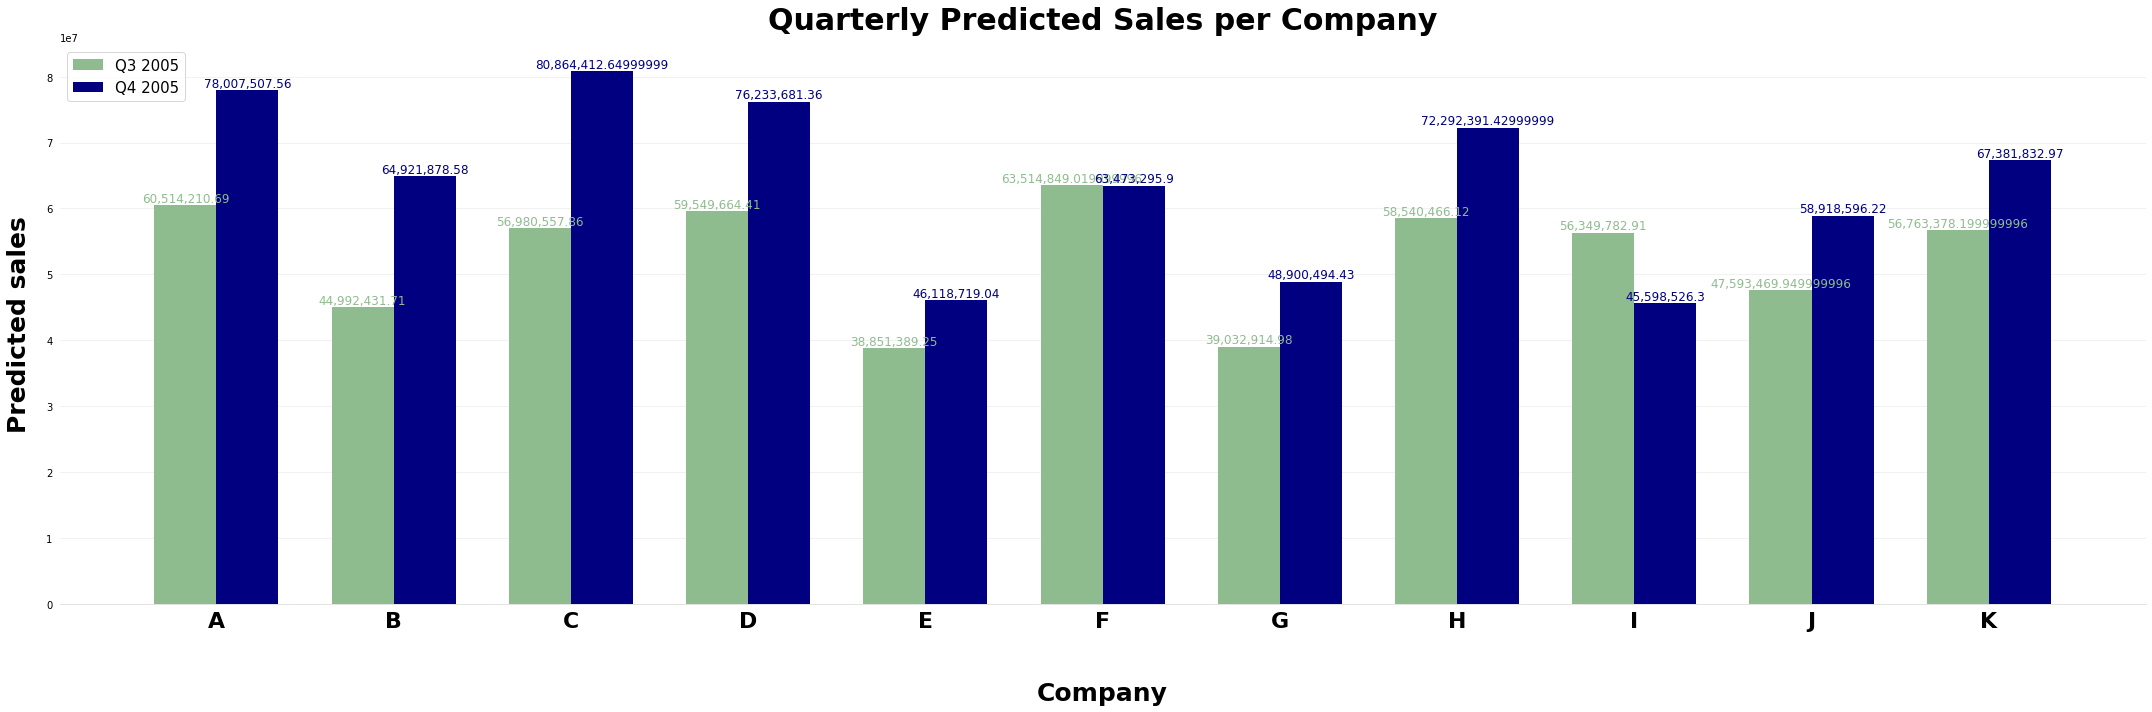

In [24]:
fig, ax = plt.subplots(figsize=(30, 10))
x = np.arange(len(q_trans_report.company.unique()))
bar_width = 0.35
b1 = ax.bar(x, q_trans_report.loc[q_trans_report['report_quarter'] == '2005Q3', 'predicted_sales'],
            width=bar_width,color="darkseagreen",label='Q3 2005')
b2 = ax.bar(x + bar_width, q_trans_report.loc[q_trans_report['report_quarter'] == '2005Q4', 'predicted_sales'],
            width=bar_width,color="navy",label='Q4 2005')

# Fix the axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(q_trans_report.company.unique(),size=22,fontweight="bold")

ax.legend(loc=2, prop={'size': 15})

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Company', labelpad=50, size=25, fontweight="bold")
ax.set_ylabel('Predicted sales', labelpad=15, size=25,fontweight="bold")
ax.set_title('Quarterly Predicted Sales per Company', pad=15, size=30,fontweight="bold")

fig.tight_layout()

for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)

#### To compare the alternative data (transaction_data) proportion of the actual dataset reported on the pnl, we need to merge the two dataframes to understand how much can be explained per company per quarter

Before we merge the two datasets, let us revamp the reported dataset into a structure similar to transaction dataset

In [25]:
reported_data_clean=reported_data
reported_data_clean.company = reported_data_clean.company.str.strip()
reported_data_clean.company = reported_data_clean.company.str[-1]
display(reported_data_clean.head(5))
q_act_report = reported_data_clean.groupby(['company','report_quarter'],as_index=False)['reported_sales'].sum()
display(q_act_report.head(5))

company report_period_start report_period_end  reported_sales report_quarter
0       A          2005-01-07        2005-09-30       632434016         2005Q3
1       B          2005-01-07        2005-09-30      1130209885         2005Q3
2       C          2005-01-07        2005-09-30       880349619         2005Q3
3       D          2005-01-07        2005-09-30      1110601241         2005Q3
4       E          2005-01-07        2005-09-30       744004104         2005Q3

company report_quarter  reported_sales
0       A         2005Q3       632434016
1       A         2005Q4       657731377
2       B         2005Q3      1130209885
3       B         2005Q4       903037698
4       C         2005Q3       880349619

In [26]:
q_compare_sales = pd.merge(q_act_report,q_trans_report,how = 'inner', on = ['company','report_quarter'])
q_compare_sales["prediction_accuracy"]=(q_compare_sales["predicted_sales"]/q_compare_sales["reported_sales"])
q_compare_sales

company report_quarter  reported_sales  predicted_sales  \
0        A         2005Q3       632434016     60514210.690   
1        A         2005Q4       657731377     78007507.560   
2        B         2005Q3      1130209885     44992431.710   
3        B         2005Q4       903037698     64921878.580   
4        C         2005Q3       880349619     56980557.860   
5        C         2005Q4       924367100     80864412.650   
6        D         2005Q3      1110601241     59549664.410   
7        D         2005Q4      1344938103     76233681.360   
8        E         2005Q3       744004104     38851389.250   
9        E         2005Q4       739986482     46118719.040   
10       F         2005Q3       732961358     63514849.020   
11       F         2005Q4       605059601     63473295.900   
12       G         2005Q3       567538584     39032914.980   
13       G         2005Q4       571511354     48900494.430   
14       H         2005Q3       982309021     58540466.120   
15       H         2005Q4      1485545932     72292391.430   
16       I         2005Q3       739365502     56349782.910   
17       I         2005Q4       442613764     45598526.300   
18       J         2005Q3       792431275     47593469.950   
19       J         2005Q4       981029918     58918596.220   
20       K         2005Q3      1223167752     56763378.200   
21       K         2005Q4      1360774124     67381832.970   

    prediction_accuracy  
0                 0.096  
1                 0.119  
2                 0.040  
3                 0.072  
4                 0.065  
5                 0.087  
6                 0.054  
7                 0.057  
8                 0.052  
9                 0.062  
10                0.087  
11                0.105  
12                0.069  
13                0.086  
14                0.060  
15                0.049  
16                0.076  
17                0.103  
18                0.060  
19                0.060  
20                0.046  
21                0.050

In [27]:
q_compare_sales_mean=q_compare_sales.groupby('company',as_index=False)['prediction_accuracy'].mean()
q_compare_sales_mean.sort_values(by=['prediction_accuracy'], ascending = False)

company  prediction_accuracy
0        A                0.107
5        F                0.096
8        I                0.090
6        G                0.077
2        C                0.076
9        J                0.060
4        E                0.057
1        B                0.056
3        D                0.055
7        H                0.054
10       K                0.048

In [28]:
## let's aggregate all the values per firm and use that as independent variables for our prediction


trans_df_daily = txn_data_clean.groupby(['company','Date'],as_index=False).agg(
    num_items = ('item_id', 'nunique'),
    avg_price = ('item_price', 'mean'), 
    total_users = ('user_id','nunique'),
     ## this is an assumption that if we don't count the unique customers, this basically gives total orders
    total_txns = ('user_id','count'),
    total_qty = ('item_quantity','sum'),
    total_sales = ('predicted_sales','sum')   
)

trans_df_daily["cust_freq"]=trans_df_daily["total_txns"]/trans_df_daily["total_users"]
trans_df_daily["per_txn_value"]=trans_df_daily["total_sales"]/trans_df_daily["total_txns"]
trans_df_daily["per_user_spend"]=trans_df_daily["total_sales"]/trans_df_daily["total_users"]
trans_df_daily.head(5)


company       Date  num_items  avg_price  total_users  total_txns  \
0       A 2005-07-01          5     66.419          976         978   
1       A 2005-07-02          5     65.971          998        1000   
2       A 2005-07-03          5     65.484         1017        1019   
3       A 2005-07-04          5     65.365         1017        1017   
4       A 2005-07-05          5     66.191         1026        1026   

   total_qty  total_sales  cust_freq  per_txn_value  per_user_spend  
0       9609   635641.910      1.002        649.941         651.272  
1       9889   648698.110      1.002        648.698         649.998  
2      10264   674121.360      1.002        661.552         662.853  
3      10082   655477.180      1.000        644.520         644.520  
4      10288   681633.120      1.000        664.360         664.360

company             A          B          C          D          E          F  \
Date                                                                           
2005-07-01 635641.910 502501.410 627398.070 649683.330 444318.730 682624.140   
2005-07-02 648698.110 477036.760 626402.490 649866.570 415701.080 654963.040   
2005-07-03 674121.360 496715.660 630560.260 614823.780 462457.480 709832.840   
2005-07-04 655477.180 477547.400 649423.330 629805.170 406167.090 704270.800   
2005-07-05 681633.120 513699.730 628013.230 626099.260 428628.760 714709.690   
...               ...        ...        ...        ...        ...        ...   
2005-12-27 811960.510 695148.560 870574.560 834035.350 499015.310 686145.270   
2005-12-28 843931.590 710670.080 900052.600 846517.790 497308.810 718507.400   
2005-12-29 832119.790 671553.230 881865.780 849618.660 501879.220 680553.690   
2005-12-30 817865.940 729367.770 869599.940 872178.990 526483.370 697834.080   
2005-12-31 857192.380 731720.390 877927.440 829466.940 518724.460 700271.200   

company             G          H          I          J          K  
Date                                                               
2005-07-01 396484.550 629640.500 587704.510 517328.260 621033.280  
2005-07-02 457288.080 637614.050 596511.910 536090.200 605217.750  
2005-07-03 429145.420 622273.800 600375.630 496886.420 636578.580  
2005-07-04 417575.190 619049.270 623219.550 512897.040 623313.180  
2005-07-05 408907.990 620363.860 635367.960 523153.080 625065.380  
...               ...        ...        ...        ...        ...  
2005-12-27 527844.870 820128.830 457435.550 630503.370 745837.720  
2005-12-28 526108.700 757627.270 492850.030 611081.470 710281.620  
2005-12-29 520154.030 783196.540 491104.890 636536.480 732974.290  
2005-12-30 499685.340 757977.130 497972.690 634564.390 718188.170  
2005-12-31 528669.150 770521.550 492096.380 617253.010 747494.700  

[184 rows x 11 columns]

<AxesSubplot:xlabel='Date'>

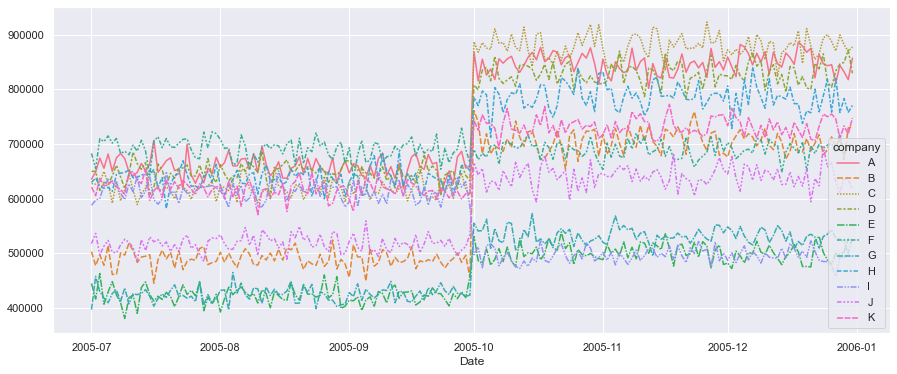

In [29]:
### considering we have been given daily data, let's understand the sales trend per firm over q3 and q4

trans_df_series = trans_df_daily[["company", "Date","total_sales"]]
trans_df_series = trans_df_series.pivot(index='Date', columns='company', values='total_sales')
display(trans_df_series)

sns.set(rc = {'figure.figsize':(15,6)})
display(sns.lineplot(data=trans_df_series))
##display(sns.lineplot(data=trans_df_series["A"]))
##display(sns.lineplot(data=trans_df_series["B"]))

### Let's try dissecting the panel data to understand the correlation between companies

In [30]:
trans_df_series.describe()

company          A          B          C          D          E          F  \
count      184.000    184.000    184.000    184.000    184.000    184.000   
mean    752835.425 597360.382 749157.448 737952.966 461794.067 690152.962   
std      97131.049 110187.252 131514.228  92722.375  42586.966  17234.106   
min     609015.180 444666.920 588868.830 599672.530 380073.650 635551.460   
25%     657242.767 488037.117 618615.965 649159.260 422851.490 679560.432   
50%     754264.885 588850.215 742309.080 735488.475 467068.545 692166.245   
75%     848610.177 705135.282 877756.830 827831.260 500597.815 701691.062   
max     886943.850 761041.320 923607.800 872178.990 538719.250 729020.350   

company          G          H          I          J          K  
count      184.000    184.000    184.000    184.000    184.000  
mean    477898.964 711048.139 554066.898 578869.925 674702.235  
std      55553.459  77935.522  60457.726  64133.350  60072.937  
min     395932.550 581527.910 457435.550 484557.110 570223.460  
25%     424137.128 638435.277 494183.198 517268.665 617438.860  
50%     479451.995 698236.080 553936.125 576431.470 672606.215  
75%     530626.167 785659.002 613554.393 639418.005 733054.250  
max     572606.040 840910.260 650537.820 694639.830 772649.690

In [31]:
## there is no point running correlation on quarterly data, hence we ran it over daily sales of each company

## trans_df_series.info()

cormat = trans_df_series.corr()
cormat

company      A      B      C      D      E      F      G      H      I      J  \
company                                                                         
A        1.000  0.969  0.973  0.961  0.911  0.012  0.949  0.942 -0.952  0.946   
B        0.969  1.000  0.974  0.967  0.920 -0.024  0.953  0.944 -0.953  0.943   
C        0.973  0.974  1.000  0.970  0.917 -0.000  0.955  0.955 -0.957  0.956   
D        0.961  0.967  0.970  1.000  0.922 -0.005  0.949  0.950 -0.955  0.943   
E        0.911  0.920  0.917  0.922  1.000  0.005  0.902  0.901 -0.903  0.888   
F        0.012 -0.024 -0.000 -0.005  0.005  1.000 -0.042 -0.042  0.008 -0.013   
G        0.949  0.953  0.955  0.949  0.902 -0.042  1.000  0.933 -0.940  0.932   
H        0.942  0.944  0.955  0.950  0.901 -0.042  0.933  1.000 -0.933  0.934   
I       -0.952 -0.953 -0.957 -0.955 -0.903  0.008 -0.940 -0.933  1.000 -0.939   
J        0.946  0.943  0.956  0.943  0.888 -0.013  0.932  0.934 -0.939  1.000   
K        0.946  0.950  0.952  0.947  0.903  0.038  0.934  0.923 -0.940  0.934   

company      K  
company         
A        0.946  
B        0.950  
C        0.952  
D        0.947  
E        0.903  
F        0.038  
G        0.934  
H        0.923  
I       -0.940  
J        0.934  
K        1.000

## Inferences on Q2 & Q3: 


Comparing the **absolute sales value analysis:** 

- As per the reported data - **Company H, D, K, and B (bad predictors)** on an average have the highest quartery sales amongst the eleven unique firms whereas from the alternative data's prediction accuracy, it is clear that the accuracy for these firms would be lower as they have much larger reported sales compared to the other firms. 

--- 
From a basic accuracy prediction point of view, let's define prediction_accuracy as the follows: 

**Prediction Accuracy = Predicted Sales/Actual Reported Sales**

- I have purposely labelled these columns with the word **predicted** to showcase that transaction data can never be purely indicative of the actual sales reported by the companies. 

- No firm would give their data freely to a buy-side firm and these data points usually come from a mediator, and as the number of middle-layers between the buy-side firm's data acquisition process and the actual company data increases, the prediction accuracy goes down. 

From a very preliminary analysis, it would seem like the transaction data is a **good predictor for company A, F, and I**, but we also need to note the following biases: 

- Actual reported sales for these firms are way lower compared to the other firms, which means a lower denominator, and hence improving the accuracy value. 

It is clear that absolute values are not comparable, as a trading strategy, I would try to look at the time series **trend analysis** to give me an accurate picture of seasonality & changes in sales from the previous quarter. With the **daily time series plot**, we can make the following inferences: 

- From a stationarity point of view, **the data is quite stationary within individual quarter time frames but there is definitely a jump in sales from Q3 to Q4, could be a seasonality component** 

**A good predictor for:** 
- Company E & F clustered together would typically not improve heavily in their sales value from Q3 to Q4, so even if we had reported sales for Q3, we can predict Q4 to be relatively the same - which is the case. 
- Company H would most likely be having a heavy jump in sales from Q3 to Q4, and reported sales highly advoates this spike in sales for H. 

**A bad predictor for:** 
- Company A, C, and G would most likely be having a heavy jump in sales from Q3 to Q4, but reported sales show stability across both quarters. 


**If we can assume the following: absolute values of reported data and transactional data are similar and the transaction data given to us is genuine (real store transactions), then we can make the following inferences from the correlation matrix:**

**A good predictor**:

- **All company sales (A-K) except company F & company I are highly positively correlated to each other. Market-neutral (like Woodline's) strategies involve long and short positions in two different securities with a positive correlation.** The two offsetting positions form the basis for a hedging strategy that seeks to benefit from either a positive or negative trend. **A pairs trade strategy is based on the historical correlation of two securities**. The securities in a pairs trade must have a high positive correlation, which is the primary driver behind the strategy’s profits. A pairs trade strategy is best deployed when a trader identifies a correlation discrepancy. Relying on the historical notion that the two securities will maintain a specified correlation, the pairs trade can be deployed when this correlation falters.

- **Sales of Company I are highly negatively correlated to all the other companies (except F)** in the correlation matrix. Again, from the trading point of view - the negative correlations can be used to **diversify the portfolio and reduce overall risk**. 


**A bad predictor:**

- **Company F has very low correlation to all the other companies**. It could be utilized for a diversification trading strategy, but from a sales prediction behaviour - hypothetically if we only had sales of company F from alternative data vendor, we cannot predict/extrapolate the sales of other companies. **Additionally, if there’s no discernible correlation between two underlyings, there’s no way to enter into a pairs trade involving the two with a high degree of confidence in the potential outcome.**


**This can also be validated with the actual sales results evident in the reported data for Company F & Company I**

## Q4: Are there any potential issues that could bias your analysis? 

- It could be the case that the alternative data vendor has more bias towards data for these companies as they are probably more involved with these company user transactions (example Company's A's users are mainly transacting with the data vendor's platform) 
- Interestingly, all of the companies are only selling 5 products, this again shows the lack of representation of the total product assortment that the companies might have but does not come as part of the intersection betwen alternative data vendor and the hedge fund. There could also be a bias as potentially the data vendor has been asked to share the sales of 5 specific products across the 11 companies. 
- In general there could be a lot of selection bias in terms of data, for example the user_ids provided to us are only of that population which is transacting online, the ones which are not might represent a huge population of our reported sales. 
- One thing we know for sure is that, there is no historical bias as such because we are given q3 & q4 transactional data and the reported sales are also part of q3 and q4.
- There is a possibility that our data cleanup process deleted a few critical rows (observations) that significantly affect the prediction power

## Experiment 1: Trying out a bias factor multiplier analysis based on real-world alternative data issues

- Cheking if unit dynamics are creating accuracy errors: let's try improving accuracy with a multiplier of 1,000 to the item_price, it is usally the case that alternative data providers give data per one thousand dollars in the sales price. (a pure assumption to see the change in accuracy) 

In [32]:
## a multiplier of 1,000 to item price is the same as multiplying 1,000 to the predicted sales

q_compare_sales_test=q_compare_sales
q_compare_sales_test["Predicted_sales_test"]=q_compare_sales_test["predicted_sales"]*1000
q_compare_sales_test["prediction_accuracy_test"]=(q_compare_sales_test["Predicted_sales_test"]/q_compare_sales_test["reported_sales"])


In [33]:
q_compare_sales_test_mean=q_compare_sales_test.groupby('company',as_index=False)['prediction_accuracy_test'].mean()
q_compare_sales_test_mean.sort_values(by=['prediction_accuracy_test'], ascending = False)

company  prediction_accuracy_test
0        A                   107.143
5        F                    95.780
8        I                    89.617
6        G                    77.170
2        C                    76.103
9        J                    60.059
4        E                    57.272
1        B                    55.851
3        D                    55.151
7        H                    54.129
10       K                    47.962

### Even though 1,000 is an abstract multiplier, it is quite common to label columns on a per 1,000 or per 1,000,000 level - and we clearly see that with this multiplier, company A, F, and I are highly indicative of the actual reported sales (+80% accuracy)

## Q5: Are there any companies that are more popular than others? How did you measure “popularity”?

In [34]:
## let's add more columns like user_freq,avg_order_value, qty_per_order, etc. 

trans_df = trans_df_daily
trans_df["cust_freq"]=trans_df["total_txns"]/trans_df["total_users"]
trans_df["per_txn_value"]=trans_df["total_sales"]/trans_df["total_txns"]
trans_df["per_user_spend"]=trans_df["total_sales"]/trans_df["total_users"]
trans_df.head(5)

company       Date  num_items  avg_price  total_users  total_txns  \
0       A 2005-07-01          5     66.419          976         978   
1       A 2005-07-02          5     65.971          998        1000   
2       A 2005-07-03          5     65.484         1017        1019   
3       A 2005-07-04          5     65.365         1017        1017   
4       A 2005-07-05          5     66.191         1026        1026   

   total_qty  total_sales  cust_freq  per_txn_value  per_user_spend  
0       9609   635641.910      1.002        649.941         651.272  
1       9889   648698.110      1.002        648.698         649.998  
2      10264   674121.360      1.002        661.552         662.853  
3      10082   655477.180      1.000        644.520         644.520  
4      10288   681633.120      1.000        664.360         664.360

### Popularity can be measured by: 

**Total number of unique users** (this is a fair metric, as it can talk about the vast customer base of each company, in any scenario, metrics around customers are the best way to showcase the popularity of firms)

---
**Customer frequency** (I believe this metric compares firms which have different vintages, for example a firm which was started recently should be differentiated from a firm that has been in existence for a long time, hence customer frquency has the ability to give a loyalty score (sort of) to each firm's popularity) 

---

**Per user spend on that company** (although there can be biases with the kind of population catered to by the companies, it gives a good idea on the willingness/purchasing power of a consumer. A user who is willing to spend a lot on specific companies and if we assume these companies are of the same type, then that could be a healthy predictive metric for investment. 

---

**Total transactions** (this is not the best popularity comparison metric, but it can be used effectively as a proxy for total sales)

### Let's sort and rank based on the above metrics - we can do this on a per quarter level as well (not required to answer the qs) to see if there is some kind of seasonality associated with certain firms.

In [35]:
## let's aggregate all the values per firm and use that as independent variables for our prediction


trans_df_comp = txn_data_clean.groupby('company',as_index=False).agg(
    total_users = ('user_id','nunique'),
     ## this is an assumption that if we don't count the unique customers, this basically gives total orders
    total_txns = ('user_id','count'),
    total_qty = ('item_quantity','sum'),
    total_sales = ('predicted_sales','sum')   
)

trans_df_comp["cust_freq"]=trans_df_comp["total_txns"]/trans_df_comp["total_users"]
trans_df_comp["per_txn_value"]=trans_df_comp["total_sales"]/trans_df_comp["total_txns"]
trans_df_comp["per_user_spend"]=trans_df_comp["total_sales"]/trans_df_comp["total_users"]

## trans.df
## txn_data_clean.groupby(['company','report_quarter'],as_index=False).sum()
## trans_df_comp.head(5)

In [36]:
print('Top 5 companies as per total users')
display(trans_df_comp.sort_values(by=['total_users'], ascending = False).head(5))
print('Top 5 companies as per customer frequency')
display(trans_df_comp.sort_values(by=['cust_freq'], ascending = False).head(5))
print('Top 5 companies as per customer spend on the company')
display(trans_df_comp.sort_values(by=['per_user_spend'], ascending = False).head(5))
print('Top 5 companies as per total transactions')
display(trans_df_comp.sort_values(by=['total_txns'], ascending = False).head(5))

Top 5 companies as per total users


company  total_users  total_txns  total_qty   total_sales  cust_freq  \
7        H       168402      207331    2060945 130832857.550      1.231   
10       K       168205      207396    2016283 124145211.170      1.233   
1        B       168186      207357    2248471 109914310.290      1.233   
2        C       168084      207040    2231549 137844970.510      1.232   
6        G       168065      206805    2067559  87933409.410      1.231   

    per_txn_value  per_user_spend  
7         631.034         776.908  
10        598.590         738.059  
1         530.073         653.528  
2         665.789         820.096  
6         425.200         523.211

Top 5 companies as per customer frequency


company  total_users  total_txns  total_qty   total_sales  cust_freq  \
10       K       168205      207396    2016283 124145211.170      1.233   
1        B       168186      207357    2248471 109914310.290      1.233   
3        D       167951      207006    2102523 135783345.770      1.233   
5        F       167963      206937    1838508 126988144.920      1.232   
8        I       168056      207026    1656279 101948309.210      1.232   

    per_txn_value  per_user_spend  
10        598.590         738.059  
1         530.073         653.528  
3         655.939         808.470  
5         613.656         756.048  
8         492.442         606.633

Top 5 companies as per customer spend on the company


company  total_users  total_txns  total_qty   total_sales  cust_freq  \
0       A       168044      206788    2102675 138521718.250      1.231   
2       C       168084      207040    2231549 137844970.510      1.232   
3       D       167951      207006    2102523 135783345.770      1.233   
7       H       168402      207331    2060945 130832857.550      1.231   
5       F       167963      206937    1838508 126988144.920      1.232   

   per_txn_value  per_user_spend  
0        669.873         824.318  
2        665.789         820.096  
3        655.939         808.470  
7        631.034         776.908  
5        613.656         756.048

Top 5 companies as per total transactions


company  total_users  total_txns  total_qty   total_sales  cust_freq  \
10       K       168205      207396    2016283 124145211.170      1.233   
1        B       168186      207357    2248471 109914310.290      1.233   
7        H       168402      207331    2060945 130832857.550      1.231   
2        C       168084      207040    2231549 137844970.510      1.232   
8        I       168056      207026    1656279 101948309.210      1.232   

    per_txn_value  per_user_spend  
10        598.590         738.059  
1         530.073         653.528  
7         631.034         776.908  
2         665.789         820.096  
8         492.442         606.633

### Although not very different results across the popularity metrics that were proposed above, we see some variations in the company rankings: 

- **Total number of users:** Company H > Company K > Company B > Company C > Company G
- **Customer Frequency:** Company K > Company B > Company D > Company F > Company I
- **Consumer spend:** Company A > Company C > Company D > Company H > Company F
- **Total Transactions:** Company K > Company B > Company H > Company C > Company I


Assuming equal weightage to all the above metrics in constructing our popularity index, most of the results clearly indicate that company K does have a lot of user popularity followed by company H. Interestingly, a few firms like A & C which do not have that many transactions/sales, but have relatively high user spending compared to other firms - giving us an insight that this could be potentially a luxury store that requires high consumer spending. 

## Are users transacting from multiple companies? If yes, then how many?

num_comp  total_user
0          1       38812
1          2       76770
2          3      106465
3          4      109153
4          5       83897
5          6       47778
6          7       19685
7          8        5631
8          9        1136
9         10         132
10        11           9

Text(0, 0.5, 'Number of Users')

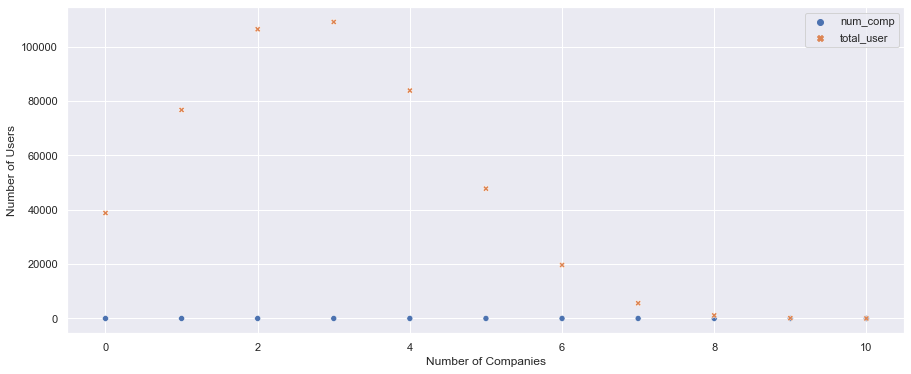

In [37]:
user_comp_popular = txn_data_clean.groupby(['company','user_id'],as_index=False)['predicted_sales'].sum()
##txn_data_clean.head()

# user_comp_popular = user_comp_popular.pivot(index='user_id', columns='company', values='predicted_sales')
# user_comp_popular

## total_users= user_df.agg(total_user = ('user_id','nunique'))

user_df = user_comp_popular.groupby('user_id',as_index=False).agg(
    num_comp = ('company','nunique'))

user_df_segment= user_df.groupby('num_comp',as_index=False).agg(
    total_user = ('user_id','nunique'))

display(user_df_segment)

sns.scatterplot(data=user_df_segment)
plt.xlabel('Number of Companies')
plt.ylabel('Number of Users')

#### Considering we have a set of 489,468 users, we can see an increasing trend in the number of companies transacted until 3 companies (20% of the users), post which the distribution becomes right skewed and a very small proportion of users are interacting with all companies. 

### This means that there are definitely cross-selling and cross-popularity possibilities between different companies and a trading strategy could speculate their trades based on user behaviour of highly correlated firms. 

---

# Appendix 

#### Experiment 2: Running a cross-sectional regression to get prediction power of transactional data

In [38]:
## let's aggregate all the values per firm and use that as independent variables for our prediction


trans_df = txn_data_clean.groupby(['company','report_quarter'],as_index=False).agg(
    num_items = ('item_id', 'nunique'),
    avg_price = ('item_price', 'mean'), 
    total_users = ('user_id','nunique'),
     ## this is an assumption that if we don't count the unique customers, this basically gives total orders
    total_txns = ('user_id','count'),
    total_qty = ('item_quantity','sum'),
    total_sales = ('predicted_sales','sum')   
)
## trans.df
## txn_data_clean.groupby(['company','report_quarter'],as_index=False).sum()
trans_df.head(5)

company report_quarter  num_items  avg_price  total_users  total_txns  \
0       A         2005Q3          5     65.841        82010       91824   
1       A         2005Q4          5     65.905       102877      114964   
2       B         2005Q3          5     48.904        82159       92120   
3       B         2005Q4          5     48.954       102884      115237   
4       C         2005Q3          5     61.793        82366       92117   

   total_qty  total_sales  
0     918931 60514210.690  
1    1183744 78007507.560  
2     920529 44992431.710  
3    1327942 64921878.580  
4     922114 56980557.860

In [39]:
X = trans_df[["total_sales"]]

## tried with multiple factors, but this did not work well with multicorrelated factors
## X = trans_df[["total_sales","total_users","total_qty","avg_price"]]
y = q_act_report["reported_sales"]
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         reported_sales   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     4.735
Date:                Sun, 26 Jun 2022   Prob (F-statistic):             0.0417
Time:                        17:24:25   Log-Likelihood:                -456.80
No. Observations:                  22   AIC:                             917.6
Df Residuals:                      20   BIC:                             919.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.804e+08   2.85e+08      0.983      0.337   -3.14e+08    8.75e+08
total_sales    10.4116      4.785      2.176      0.042       0.431      20.393
==============================================================================
Omnibus:                        1.751   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.087
Skew:                           0.209   Prob(JB):                        0.581
Kurtosis:                       1.994   Cond. No.                     3.02e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### A cross-sectional regression does not give any incremental knowledge on how the cumalative transactional sales could be correlated (predictor) with the actual reported sales, the primary reason for that is due to the sparsity of data in the reported sales dataframe (only 22 observations on a quarterly level) which are too low to predict accurately.

### Deep-dive analysis: We can also see a use case in which we can build a segmentation for these consumers to have a deeper understanding of the quality of customer popularity

K-Means: Is an iterative algorithm in which each observation belongs to the cluster with the nearest mean (centroids).

K-Means is a distance-based algorithm. Because of that, it’s super important to normalize, standardize, or choose any other option in which the distance has some comparable meaning for all the columns. MinMaxScaler, it’s an excellent tool for it.

In [40]:
## trans_df_daily.info()
## trans_df.info()

In [41]:
fig = px.scatter_matrix(trans_df_daily.drop(["company","Date"],axis=1),
width=1200, height=1600)
fig.show()

In [42]:
fig2 = px.scatter_3d(trans_df_daily, x="total_users", y="total_sales",z="total_qty",
                     color="per_user_spend",size="cust_freq")
fig2.update_layout(title="5 Imp Features Representation")
fig2.show()

In [43]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import numpy as np
X=trans_df_daily.drop(["company","Date"],axis=1)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
fig = go.Figure(data=go.Scatter(x=np.arange(1,11),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=3,
            y=inertia[2],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])